In [1]:
import os

# Set the working directory
working_directory = "/Users/saeah/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1"
os.chdir(working_directory)

In [2]:
import os
print(os.getcwd())

/Users/saeah/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [3]:
import torch

# Check if MPS is available
if torch.backends.mps.is_available():
    print(f"MPS is available. Using GPU.")
else:
    print("MPS is not available. Using CPU.")

MPS is available. Using GPU.


In [4]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Ensure reproducibility
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Hyperparameters
batch_size = 128
num_classes = 43  # Adjust for GTSRB
epochs = 40
learning_rate = 0.01
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

### DATA AUGMENTATION
# Transformations for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Small rotations and translations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color variations
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),  # Simulating occlusions
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transformations for testing (NO augmentations, only normalization)
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset class for GTSRB
class GTSRBDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)

        # Reorder columns: Move 'ClassId' and 'Path' to the first two positions
        columns = self.data.columns.tolist()
        new_order = ['ClassId', 'Path'] + [col for col in columns if col not in ['ClassId', 'Path']]
        self.data = self.data[new_order]

        # self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # img_name = os.path.join(self.root_dir, self.data.iloc[idx, 1])
        # img_name = os.path.join(self.root_dir, str(self.data.iloc[idx, 1]))
        img_path = self.data.iloc[idx, 1]  # Use path directly from CSV
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 0])

        if self.transform:
            image = self.transform(image)

        return image, label

# Load datasets - Apply different transforms for train and test
train_dataset = GTSRBDataset(csv_file="Train.csv", transform=train_transform)
test_dataset = GTSRBDataset(csv_file="Test.csv", transform=test_transform)







# BALANCE THE DATASET

from collections import Counter
from torch.utils.data import WeightedRandomSampler

# Get class distribution
class_counts = train_dataset.data['ClassId'].value_counts().to_dict()
max_samples = max(class_counts.values())  # Maximum images in a single class

# Create a new balanced dataset by oversampling underrepresented classes
balanced_data = []

for class_id, count in class_counts.items():
    class_samples = train_dataset.data[train_dataset.data['ClassId'] == class_id]
    
    # If the class has fewer samples, randomly duplicate its entries
    if count < max_samples:
        extra_samples = class_samples.sample(n=max_samples - count, replace=True, random_state=RANDOM_SEED)
        class_samples = pd.concat([class_samples, extra_samples])
    
    balanced_data.append(class_samples)

# Concatenate all balanced data
balanced_df = pd.concat(balanced_data).reset_index(drop=True)

# Update the dataset
train_dataset.data = balanced_df

# Create new DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)














# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# CNN Model
class LeNetCustom(nn.Module):
    def __init__(self, num_classes):
        super(LeNetCustom, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout added here
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

# Initialize lists to track accuracies and losses
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

# Training function
def train_model(model, optimizer, loss_fn, train_loader, test_loader, device):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct_pred = 0
        num_examples = 0
        
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)

            optimizer.zero_grad()
            logits = model(features)
            loss = loss_fn(logits, targets)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * targets.size(0)
            correct_pred += (logits.argmax(dim=1) == targets).sum().item()
            num_examples += targets.size(0)

        train_loss = running_loss / num_examples
        train_acc = correct_pred / num_examples * 100
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Evaluate on test set
        test_loss, test_acc = evaluate_model(model, loss_fn, test_loader, device, print_output=False)

        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
    
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Evaluation function
def evaluate_model(model, loss_fn, data_loader, device, print_output=True):
    model.eval()
    correct_pred = 0
    num_examples = 0
    total_loss = 0.0
    
    with torch.no_grad():
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)
            logits = model(features)

            loss = loss_fn(logits, targets)
            total_loss += loss.item() * targets.size(0)
            correct_pred += (logits.argmax(dim=1) == targets).sum().item()
            num_examples += targets.size(0)
    
    test_loss = total_loss / num_examples
    test_acc = correct_pred / num_examples * 100

    # if print_output:
    #     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    return test_loss, test_acc
    
# Initialize model, loss function, and optimizer
model = LeNetCustom(num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# Train and evaluate the model
train_model(model, optimizer, loss_fn, train_loader, test_loader, device)
# test_losses, test_accuracies = evaluate_model(model, loss_fn, test_loader, device)

# Save the trained model
model_path = "saved_models/gtsrb_model_cnn_train.pth"
os.makedirs("saved_models", exist_ok=True)
torch.save(model.state_dict(), model_path)
print(f"Model saved at {model_path}")


Epoch 1/40 - Train Loss: 3.7621, Train Acc: 2.31% | Test Loss: 3.7601, Test Acc: 0.84%
Epoch 2/40 - Train Loss: 3.7570, Train Acc: 2.83% | Test Loss: 3.7501, Test Acc: 3.49%
Epoch 3/40 - Train Loss: 3.7281, Train Acc: 3.76% | Test Loss: 3.6941, Test Acc: 2.80%
Epoch 4/40 - Train Loss: 3.5494, Train Acc: 6.86% | Test Loss: 3.2780, Test Acc: 8.01%
Epoch 5/40 - Train Loss: 3.0007, Train Acc: 15.08% | Test Loss: 2.7613, Test Acc: 18.09%
Epoch 6/40 - Train Loss: 2.5968, Train Acc: 24.45% | Test Loss: 2.3548, Test Acc: 28.61%
Epoch 7/40 - Train Loss: 2.2636, Train Acc: 33.68% | Test Loss: 1.9637, Test Acc: 37.25%
Epoch 8/40 - Train Loss: 2.0009, Train Acc: 40.53% | Test Loss: 1.7597, Test Acc: 40.96%
Epoch 9/40 - Train Loss: 1.7931, Train Acc: 46.39% | Test Loss: 1.5817, Test Acc: 48.77%
Epoch 10/40 - Train Loss: 1.6163, Train Acc: 51.50% | Test Loss: 1.4344, Test Acc: 53.98%
Epoch 11/40 - Train Loss: 1.4599, Train Acc: 55.86% | Test Loss: 1.3321, Test Acc: 56.36%
Epoch 12/40 - Train Loss: 1

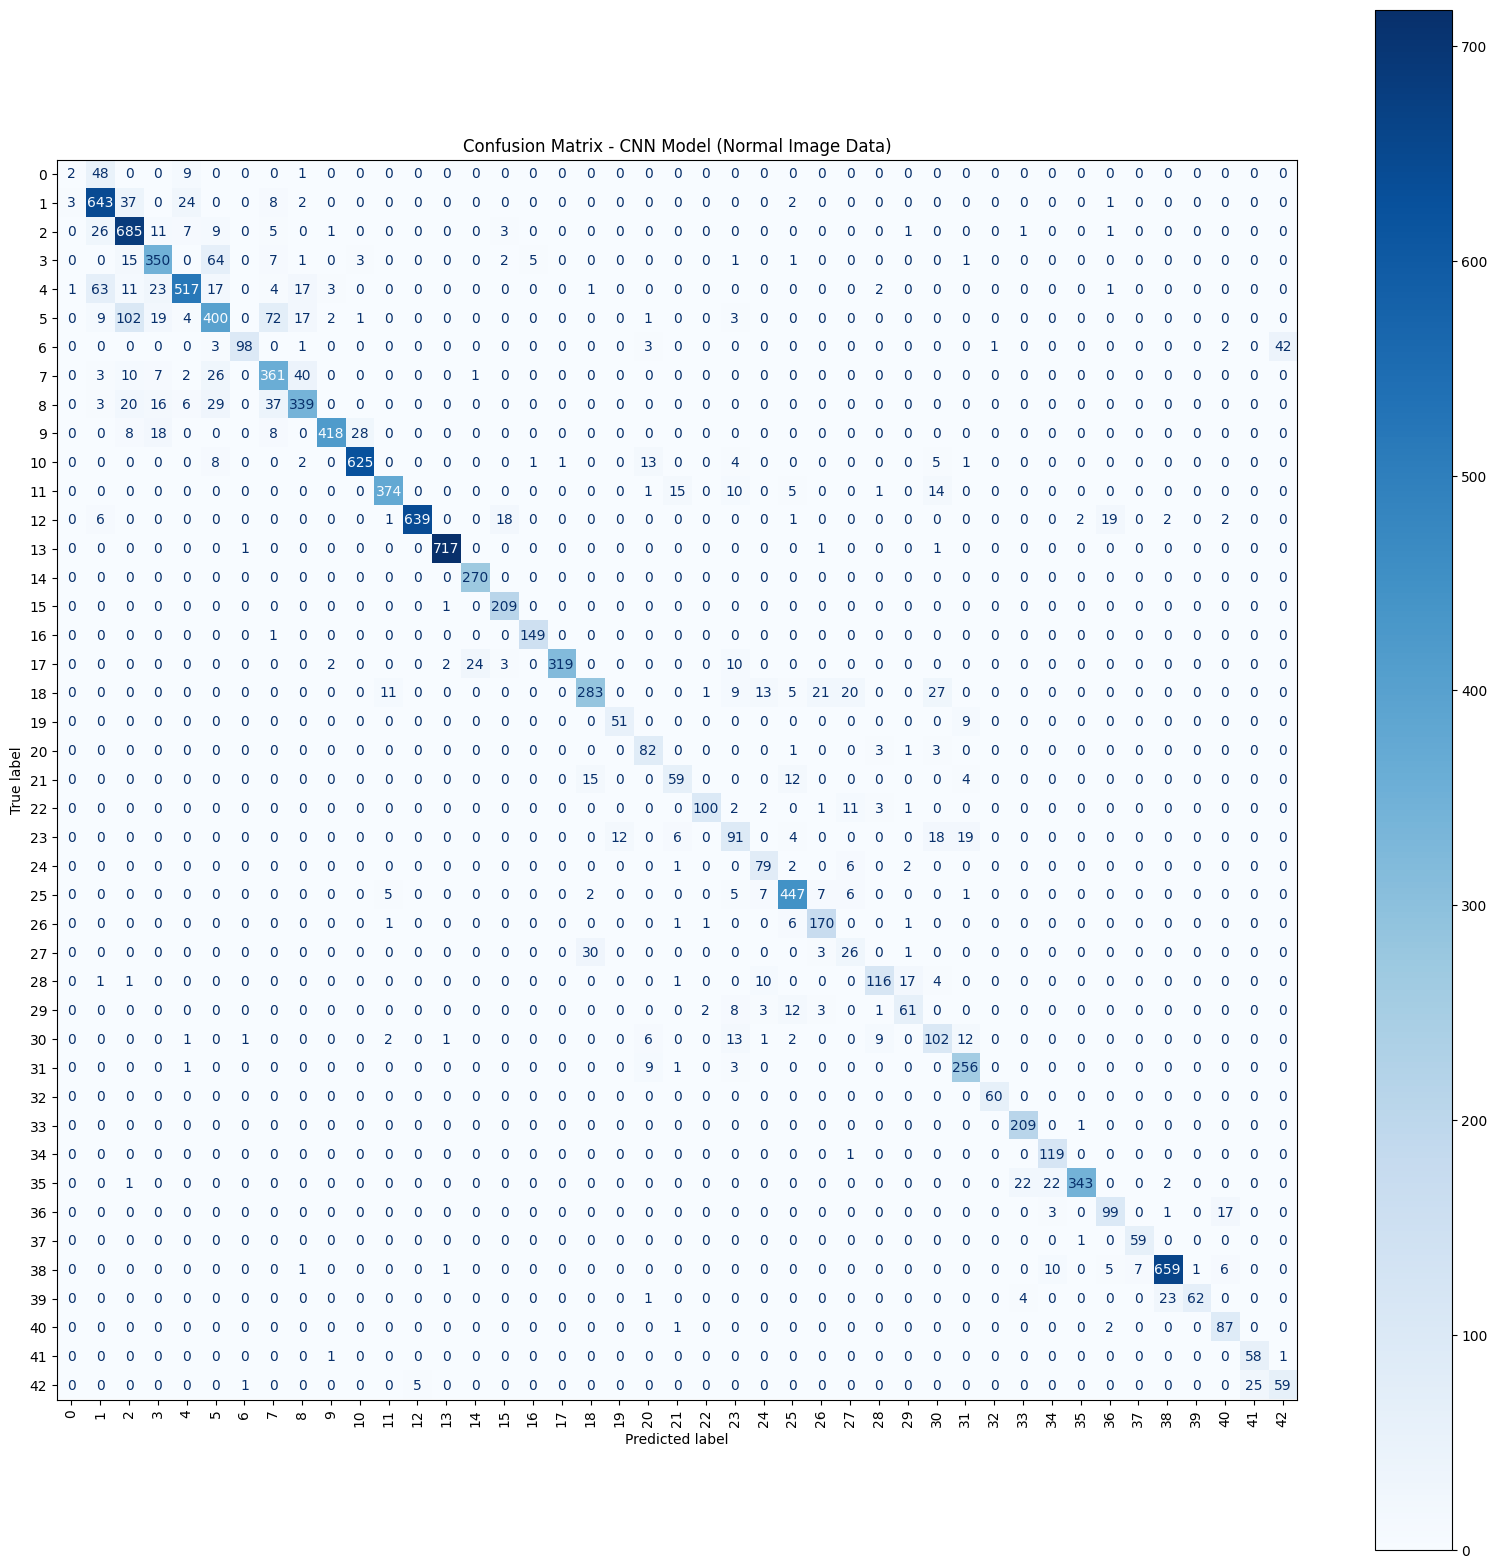

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Collect true and predicted labels for the test dataset
true_labels = []
predicted_labels = []

model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():  # Disable gradient calculations
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_classes)))

# Set a custom figure size
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust the size as needed

# Display the confusion matrix with explicit axes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')  # Pass the custom axes

# Add title and show the plot
plt.title("Confusion Matrix - CNN Model (Normal Image Data)")
plt.show()

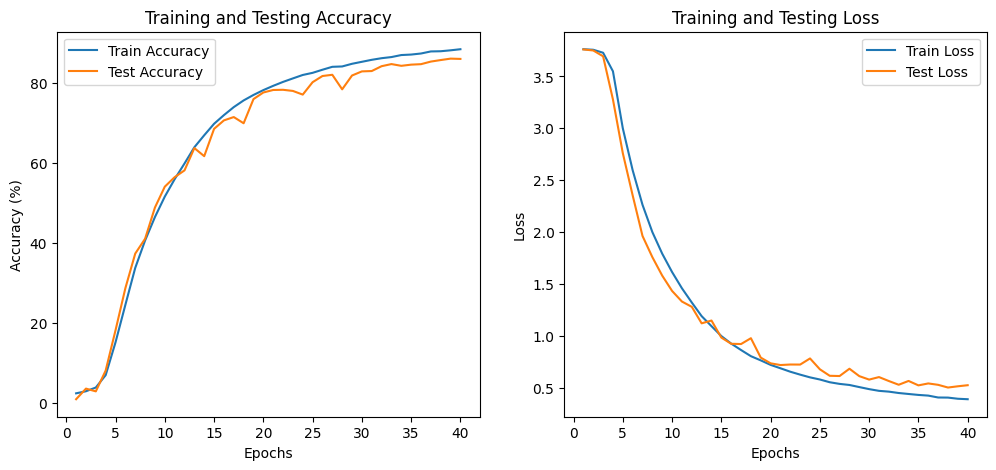

In [6]:
import matplotlib.pyplot as plt
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

plt.show()